In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import random
from sklearn.metrics import accuracy_score

## Reading Data from CSVs

In [2]:
class Data:
    def __init__(self, data, target, data_headers, target_header, perc, balance=False):
        self.data = data
        self.target = target
        self.data_headers = [h.replace('_', ' ').title() for h in data_headers]
        self.target_header = target_header.replace('_', ' ').title()
        
        for i in range(len(target)):
            target[i] = 1 if target[i] > 0 else 0
        
        self.__center()
        
        # balance data if necessary
        if balance:
            self.__balance()
        
        self.__split(perc)
    
    # centers the data (not necessary but it's a habit)
    def __center(self):
        for c in range(self.data.shape[1]):
            col = self.data[:, c]
            avg = sum(col) / len(col)
            self.data[:, c] -= avg
    
    def __balance(self):
        counts = {}
        # get data counts
        for r in self.target:
            if r not in counts:
                counts[r] = 1
            else:
                counts[r] += 1
                
        mini = min(counts, key=counts.get)
        maxi = max(counts, key=counts.get)
        
        if counts[maxi] != counts[mini]:
            ndxs = [i for i in range(len(self.target)) if self.target[i] == maxi]
            random.shuffle(ndxs)
            ndxs = ndxs[:(counts[maxi] - counts[mini])]
            for i in sorted(ndxs)[::-1]:
                self.target = np.delete(self.target, i, 0)
                self.data = np.delete(self.data, i, 0)
            self.__balance()
    
    # creates shuffles train/test data sets from the original data and target
    def __split(self, perc):
        # shuffle data
        ndxs = list(range(len(self.data)))
        random.shuffle(ndxs)
        self.temp_data = np.ones(self.data.shape)
        self.temp_target = np.ones(self.target.shape)
        for i in range(len(self.data)):
            self.temp_data[i] = self.data[ndxs[i]]
            self.temp_target[i] = self.target[ndxs[i]]
        
        # split into training and test sets
        sp = int(len(self.data) * perc)
        self.training_data = self.temp_data[:sp]
        self.training_target = self.temp_target[:sp].astype(int)
        self.testing_data = self.temp_data[sp:]
        self.testing_target = self.temp_target[sp:].astype(int)

def has_questions(li):
    for e in li:
        if '?' in e:
            return True
    return False
        
# reads data in from a .csv file, where the first line the names of the columns.
# shuffles the data based on 'perc' and splits into training and test sets as well.
def read(fname, target_ndx=0, perc=0.75, ignore=[], balance=False, cut=None):
    with open(fname, 'r') as f:
        rm = lambda li: [li[i].strip() for i in range(len(li)) if i not in ignore]
        lines = [rm(line.split(',')) for line in f.readlines()]
        lines = [l for l in lines if not has_questions(l)]
    # for removing unwanted columns
    ign = lambda line, li: [line[i].strip() for i in range(len(line)) if i not in li]
    
    if cut != None:
        lines = lines[:cut]
    
    # get headers (names of columns)
    top_line = lines[0]
    data_headers = ign(top_line, [target_ndx])
    target_header = top_line[target_ndx]
    
    # get data
    data = np.array([[float(x) for x in ign(line, [target_ndx])] for line in lines[1:]])
    # get target
    t = []
    for ndx in range(1, len(lines)):
        try:
            t.append(int(lines[ndx][target_ndx]))
        except:
            data = np.delete(data, ndx - 1)
            pass
    target = np.array(t).astype(int)
    return Data(data, target, data_headers, target_header, perc, balance)

# Feed-Forward Neural Net Implementation
3 layers only, with variable-size layers

In [3]:
class NN:
    def __init__(self, network, data, target, activation=np.tanh):
        self.network = network
        self.data = data
        self.data_length = len(data)
        self.target = target
        self.regression_term = 0.01
        self.activation = activation

    # forward propagation
    def __forward(self, input_vector):
        output = self.activation(input_vector.dot(self.weights[0]) + self.bias[0])
        scores = np.exp(output.dot(self.weights[1]) + self.bias[1])
        return scores / np.sum(scores, axis=1, keepdims=True)

    # backward propagation
    def __backward(self, probabilities):
        # intialize gradient vectors
        weight_changes = [0 for i in range(len(self.network) - 1)]
        bias_changes = [0 for i in range(len(self.network) - 1)]

        output = self.activation(self.data.dot(self.weights[0]) + self.bias[0])
        # output layer
        change = probabilities
        change[range(self.data_length), self.target] -= 1
        weight_changes[1] = (output.T).dot(change) + self.regression_term * self.weights[1]
        bias_changes[1] = np.sum(change, axis=0)

        # hidden layer
        change = change.dot(self.weights[1].T) * (1 - np.power(output, 2))
        weight_changes[0] = np.dot(self.data.T, change) + self.regression_term * self.weights[0]
        bias_changes[0] = np.sum(change, axis=0)

        return weight_changes, bias_changes

    # finds accuracy for whole dataset
    def accuracy(self, target=None, data=None):
        if target is None or data is None:
            target = self.target
            data = self.data
        return accuracy_score(target, self.predict(data)) * 100
    
    # finds loss for whole dataset
    def find_loss(self):
        # forward propagate
        f = self.__forward(self.data)
        # calculate loss
        loss = np.sum(-np.log(f[range(self.data_length), self.target]))
        loss += self.regression_term / 2 * (np.sum(np.square(self.weights[0])) + np.sum(np.square(self.weights[1])))
        return 1 / self.data_length * loss

    # runs the input through the network to predict the output
    def predict(self, input_vector):
        return np.argmax(self.__forward(input_vector), axis=1)

    # fits the network to the data provided in constructor
    def fit(self, learning_rate=0.01, num_epochs=10000, goal_acc=None, verbose=True):
        # reset weights and biases
        self.weights = [np.random.randn(self.network[i], self.network[i + 1]) for i in range(len(self.network) - 1)]
        self.bias = [np.zeros((1, self.network[i + 1])) for i in range(len(self.network) - 1)]
        
        # fit to data
        epoch = 0
        while (goal_acc == None and epoch < num_epochs) or (goal_acc != None and self.accuracy() < goal_acc):
            epoch += 1
            # forward-prop
            probs = self.__forward(self.data)
            # backward-prop
            weight_changes, bias_changes = self.__backward(probs)

            # update weights
            for i in range(len(self.network) - 1):
                self.weights[i] -= learning_rate * weight_changes[i]
                self.bias[i] -= learning_rate * bias_changes[i]
            
            # print loss
            if verbose and epoch > 0 and epoch % int(num_epochs / 10) == 0:
                if goal_acc == None:
                    print("{0}/{1}:\tLoss: {2:.2f}\tAcc: {3:.2f}%".format(
                            epoch, num_epochs, self.find_loss(), self.accuracy()))
                else:
                    print("{0}:\tLoss: {1:.2f}\tAcc: {2:.2f}%".format(
                            epoch, self.find_loss(), self.accuracy()))

# Helper function to plot a decision boundary
#    - Found at: https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.winter, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.winter)

# Determining if Breast Tumors are Benign or Malignant
Data Source: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

Based on just the average radius and average texture of a breast tumor, the network can classify if it is malignant or not 80% of the time. The data set is balanced, with an even number of benign and malignant tumors.

In [4]:
data = read("Cancer.csv", ignore=range(3, 400), balance=True)
nn = NN([2, 4, 2], data.training_data, data.training_target)
nn.fit(learning_rate=0.0000001, num_epochs=50000, goal_acc=80, verbose=True)

5000:	Loss: 0.62	Acc: 50.63%
10000:	Loss: 0.56	Acc: 79.87%


# Results
Usually between 75% and 80% accurate depending on random starting weights when the number of epochs is fixed. When the 'goal_acc' is set like it is above, the number of epochs is unlimited and the network will only stop learning when the accuracy over the whole dataset is at least the given number (80% in the example above). Because the data is balanced with an even number of malignant and benign tumors, this is better than the baseline accuracy you would get from always choosing the most common class (which would result in 50% accuracy here).

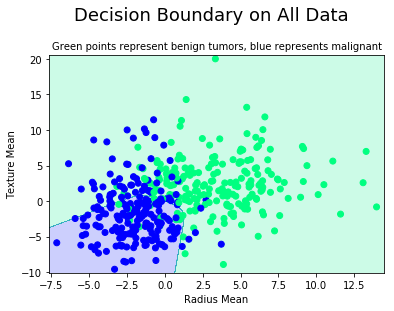

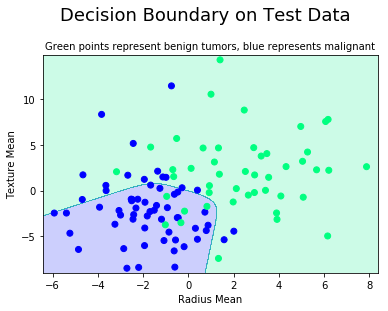

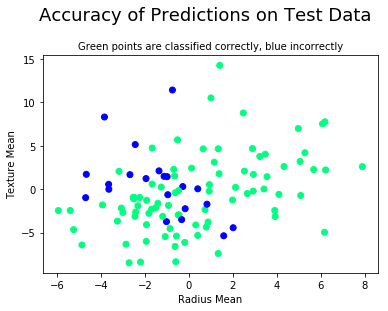

Final Accuracy on Test Data: 80.19%


In [5]:
plot_decision_boundary(lambda x: nn.predict(x), data.data, data.target)
plt.suptitle("Decision Boundary on All Data", y=1.05, fontsize=18)
plt.title("Green points represent benign tumors, blue represents malignant", fontsize=10)
plt.xlabel(data.data_headers[0])
plt.ylabel(data.data_headers[1])
plt.show()

print('\n')

plot_decision_boundary(lambda x: nn.predict(x), data.testing_data, data.testing_target)
plt.suptitle("Decision Boundary on Test Data", y=1.05, fontsize=18)
plt.title("Green points represent benign tumors, blue represents malignant", fontsize=10)
plt.xlabel(data.data_headers[0])
plt.ylabel(data.data_headers[1])
plt.show()

print('\n')

output = nn.predict(data.testing_data)
correct = [1 if output[i] == data.testing_target[i] else 0 for i in range(len(output))]
plt.scatter(data.testing_data[:, 0], data.testing_data[:, 1], c=correct, cmap=plt.cm.winter)
plt.suptitle("Accuracy of Predictions on Test Data", y=1.05, fontsize=18)
plt.title("Green points are classified correctly, blue incorrectly", fontsize=10)
plt.xlabel(data.data_headers[0])
plt.ylabel(data.data_headers[1])
plt.show()

print("Final Accuracy on Test Data: {0:.2f}%".format(nn.accuracy(data.testing_target, data.testing_data)))

# Predicing Chronic Kidney Disease
Data source: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

This uses 11 attributes about a patient to classify them as someone who will or will not have chronic kidney disease. The accuracy ends up around 60%, which is better than the 50% you could get by just guessing (the data is balanced at 50/50 between the two classes)

In [6]:
ig_list = list(range(2, 9)) + list(range(18,24))
data = read("Kidney.csv", target_ndx=11, ignore=ig_list, balance=True, cut=184)
nn = NN([11, 5, 2], data.training_data, data.training_target)
nn.fit(learning_rate=0.000001, num_epochs=50000, goal_acc=60, verbose=True)

In [7]:
print('{} attributes:\n\t'.format(len(data.data_headers)), data.data_headers)
print("Final Accuracy on Test Data: {0:.2f}%".format(nn.accuracy(data.testing_target, data.testing_data)))

11 attributes:
	 ['Age', 'Bp', 'Bgr', 'Bu', 'Sc', 'Sod', 'Pot', 'Hemo', 'Pcv', 'Wbcc', 'Rbcc']
Final Accuracy on Test Data: 62.79%


# Predicting Normal vs. Abnormal Heart Conditions from SPECT Images
Data source: https://archive.ics.uci.edu/ml/datasets/SPECTF+Heart

The data consists of 44 attributes about heart images, and the predictor classifies them into either abnormal or normal hearts. The data is balanced, with an equal number of normal and abnormal data points. The accuracy can get up to around 75%, but is set to stop at 65 to speed up the fitting process.

In [31]:
data = read("Heart.csv", balance=True)
nn = NN([44, 10, 2], data.training_data, data.training_target)
nn.fit(learning_rate=0.000001, num_epochs=50000, goal_acc=70, verbose=True)

5000:	Loss: 1.93	Acc: 51.22%
10000:	Loss: 1.70	Acc: 57.32%
15000:	Loss: 1.52	Acc: 59.76%
20000:	Loss: 1.41	Acc: 59.76%
25000:	Loss: 1.32	Acc: 59.76%
30000:	Loss: 1.24	Acc: 59.76%
35000:	Loss: 1.16	Acc: 56.10%
40000:	Loss: 1.10	Acc: 58.54%
45000:	Loss: 1.02	Acc: 59.76%
50000:	Loss: 0.96	Acc: 60.98%
55000:	Loss: 0.91	Acc: 59.76%
60000:	Loss: 0.85	Acc: 60.98%
65000:	Loss: 0.79	Acc: 68.29%
70000:	Loss: 0.76	Acc: 68.29%
75000:	Loss: 0.73	Acc: 68.29%
80000:	Loss: 0.71	Acc: 68.29%
85000:	Loss: 0.69	Acc: 69.51%
90000:	Loss: 0.67	Acc: 68.29%
95000:	Loss: 0.65	Acc: 68.29%
100000:	Loss: 0.64	Acc: 68.29%


In [32]:
print('{} attributes'.format(len(data.data_headers)))
print("Final Accuracy on Test Data: {0:.2f}%".format(nn.accuracy(data.testing_target, data.testing_data)))

44 attributes
Final Accuracy on Test Data: 60.71%
